# Weibull Analysis in Python — Hands-On Mini Project (Chapter 20.5)

This notebook accompanies **Applied Reliability Engineering** and is designed to run cleanly in **Google Colab**.

## What you’ll produce (copy-ready figures for your book)
- Weibull **PDF**, **CDF**
- **Reliability** curve *(Survival Function, R(t))*
- **Hazard rate** curve *(h(t))*
- Weibull **Probability Plot** (fit check)

All figures are saved automatically into a folder named **`figures/`** with print-quality DPI.

> **Dataset required:** `Failure_Events_CLEAR_Enhanced.xlsx`  
Place it in the Colab working directory (or upload via the provided cell).


## 0) Install dependencies (Colab)

In [1]:
# If running in Google Colab, uncomment and run this cell once
!pip install "numpy<2.0"
!pip install reliability

  Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.2 which is incompatible.


## 1) Upload dataset (Colab)

In [1]:
# If you're on Colab, run this to upload the Excel file from your computer.
# After upload, you should see 'Failure_Events_CLEAR_Enhanced.xlsx' in the file list.

from google.colab import files
uploaded = files.upload()

Saving Failure_Events_CLEAR_Enhanced.xlsx to Failure_Events_CLEAR_Enhanced (6).xlsx


## 2) Imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Weibull fitting (2-parameter Weibull)
from reliability.Fitters import Fit_Weibull_2P

## 3) Load dataset

In [4]:
DATA_FILE = "Failure_Events_CLEAR_Enhanced.xlsx"

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(
        f"{DATA_FILE} not found. Upload it first (Section 1) or place it in the working directory."
    )

df = pd.read_excel(DATA_FILE)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head(10)

Rows: 180
Columns: ['Plant', 'Event_ID', 'Asset_ID', 'Event_Type', 'Failure_Start', 'Detection_Time', 'Repair_Start', 'Return_To_Service', 'Downtime_hr', 'Planned_Flag', 'Production_Impact', 'Failure_Mode_Code', 'Failure_Mode_Text', 'Cause_Code', 'Cause_Category', 'Action_Code', 'Action_Category', 'Parts_Used_Flag', 'WorkOrder_ID', 'Comments', 'Data_Quality_Flag', 'Component_Code', 'Location_Code', 'Event_Code', 'Agent_Code', 'Response_Code', 'CLEAR_Code']


,Plant,Event_ID,Asset_ID,Event_Type,...,Event_Code,Agent_Code,Response_Code,CLEAR_Code
0,Alpha Process Plant,EV-2024-000001,MTR-302,FAILURE,...,OHT,OPR,REP,UNK-DE-OHT-OPR-REP
1,Alpha Process Plant,EV-2024-000002,PMP-107,FAILURE,...,UNK,UNK,RPL,UNK-SUC-UNK-UNK-RPL
2,Alpha Process Plant,EV-2024-000003,CV-409,TRIP,...,UNK,MEC,REP,UNK-DE-UNK-MEC-REP
3,Alpha Process Plant,EV-2024-000004,PMP-101A,FAILURE,...,UNK,OPR,ADJ,UNK-NDE-UNK-OPR-ADJ
4,Alpha Process Plant,EV-2024-000005,PMP-104,FAILURE,...,LEK,MEC,RPL,SEA-DE-LEK-MEC-RPL
5,Alpha Process Plant,EV-2024-000006,PMP-109,TRIP,...,LEK,MEC,RPL,SEA-TB-LEK-MEC-RPL
6,Alpha Process Plant,EV-2024-000007,MTR-303,FAILURE,...,UNK,MEC,RPL,BRG-DIS-UNK-MEC-RPL
7,Alpha Process Plant,EV-2024-000008,TX-508,FAILURE,...,UNK,MEC,CLN,UNK-TB-UNK-MEC-CLN
8,Alpha Process Plant,EV-2024-000009,MTR-311,TRIP,...,UNK,MEC,RPL,BRG-DE-UNK-MEC-RPL
9,Alpha Process Plant,EV-2024-000010,CV-408,FAILURE,...,UNK,UNK,RPL,UNK-SUC-UNK-UNK-RPL


## 4) Validate required columns and parse timestamps

In [5]:
required_cols = ["Asset_ID", "Event_Type", "Failure_Start"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Ensure datetime
df["Failure_Start"] = pd.to_datetime(df["Failure_Start"], errors="coerce")

# Drop rows with invalid timestamps
df = df.dropna(subset=["Failure_Start"]).copy()

df[required_cols].head(10)

,Asset_ID,Event_Type,Failure_Start
0,MTR-302,FAILURE,2023-01-16 18:24:10
1,PMP-107,FAILURE,2023-01-24 19:25:54
2,CV-409,TRIP,2023-01-26 14:28:00
3,PMP-101A,FAILURE,2023-01-30 18:13:43
4,PMP-104,FAILURE,2023-01-31 22:32:44
5,PMP-109,TRIP,2023-02-01 09:18:25
6,MTR-303,FAILURE,2023-02-04 02:12:08
7,TX-508,FAILURE,2023-02-08 11:35:01
8,MTR-311,TRIP,2023-02-08 20:40:53
9,CV-408,FAILURE,2023-03-03 18:16:51


## 5) Derive failure intervals (TTF) in hours

This dataset is **event-based** (CMMS-style). We compute **time between failure-like events** per asset:
- Filter to failure-like events (default: `FAILURE`, `TRIP`)
- Sort by asset and timestamp
- Compute time difference between consecutive failure events → `TTF_hours`


In [6]:
FAILURE_EVENTS = {"FAILURE", "TRIP"}  # edit if needed

df_fail = df[df["Event_Type"].astype(str).str.upper().isin(FAILURE_EVENTS)].copy()
df_fail["Event_Type"] = df_fail["Event_Type"].astype(str).str.upper()

# Sort and compute intervals per asset
df_fail = df_fail.sort_values(["Asset_ID", "Failure_Start"])
df_fail["TTF_hours"] = df_fail.groupby("Asset_ID")["Failure_Start"].diff().dt.total_seconds() / 3600.0

# Keep only positive intervals (drop first event per asset and any non-positive anomalies)
intervals = df_fail["TTF_hours"].dropna()
intervals = intervals[intervals > 0]

print("Derived failure intervals (hours):", len(intervals))
intervals.describe()

Derived failure intervals (hours): 113


,TTF_hours
count,113
mean,5383.95
std,4347.2
min,140.265
25%,1832.71
50%,3916.75
75%,7771.22
max,18879.6


## 6) Derive right-censored intervals (recommended)

For each asset, the time from its **last failure event** to the **end of observation window** is treated as **right-censored**.

By default, we set observation end to the latest timestamp in the dataset:
- `OBS_END = max(Failure_Start)`


In [7]:
# Observation end (edit if your study window is explicit)
OBS_END = df["Failure_Start"].max()

# Last failure-like event per asset
last_fail = df_fail.groupby("Asset_ID")["Failure_Start"].max()

# Right-censored time: from last failure to OBS_END
right_censored = (OBS_END - last_fail).dt.total_seconds() / 3600.0
right_censored = right_censored[right_censored > 0]

print("Right-censored intervals (hours):", len(right_censored))
right_censored.describe()

Right-censored intervals (hours): 48


,Failure_Start
count,48
mean,6060.03
std,5303.31
min,151.548
25%,2030.91
50%,4459.09
75%,9427.46
max,22655.1


## 7) Fit Weibull (2-parameter) with censoring

Outputs:
- **β (beta)** = shape → failure behavior  
- **η (eta)** = scale → characteristic life (63.2% cumulative failure point)


In [8]:
failures = intervals.values
censored = right_censored.values  # can be empty

if len(failures) < 3:
    raise ValueError("Not enough failure intervals to fit a Weibull model (need at least ~3).")

fit = Fit_Weibull_2P(
    failures=failures,
    right_censored=censored,
    show_probability_plot=False
)

beta = fit.beta
eta = fit.alpha

print(f"Shape β: {beta:.4f}")
print(f"Scale η: {eta:.4f} hours")

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 113/48 (29.81366% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         7977.34         628.256   6836.31   9308.82
     Beta         1.19621        0.088274   1.03512   1.38236 

Goodness of fit    Value
 Log-likelihood -1125.26
           AICc  2254.59
            BIC  2260.67
             AD  5.04371 

Shape β: 1.1962
Scale η: 7977.3381 hours


## 8) Create a plotting grid and figure-saving helper

The distribution methods require x-values (e.g., `PDF(x)`, `CDF(x)`, `SF(x)`, `HF(x)`), so we build a clean grid.

All figures are saved into `figures/` at 300 DPI for book-quality insertion.


In [9]:
# Create output folder for figures
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Build an x-grid (hours) for smooth curves
x_max = max(np.max(failures), np.max(censored) if len(censored) else 0)
x = np.linspace(0.0, x_max * 1.25, 500)

def savefig(name: str):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

## 9) Weibull PDF

Saved: figures/WBL_20_5_PDF.png


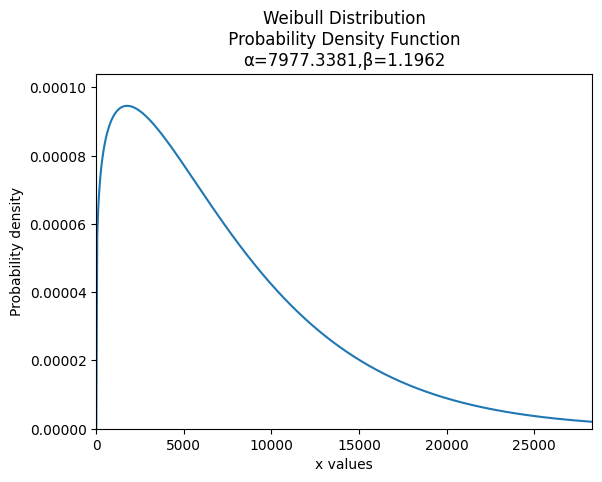

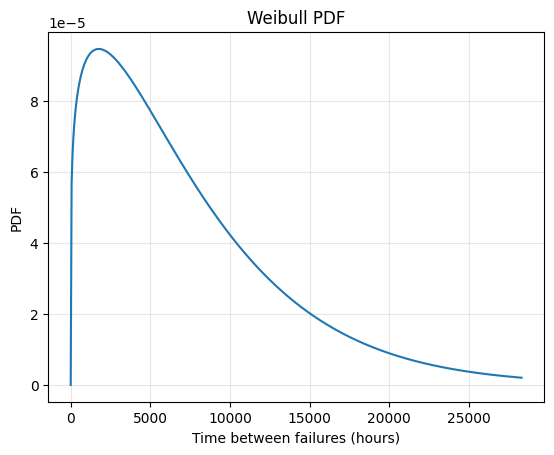

In [10]:
y_pdf = fit.distribution.PDF(x)

plt.figure()
plt.plot(x, y_pdf)
plt.xlabel("Time between failures (hours)")
plt.ylabel("PDF")
plt.title("Weibull PDF")
plt.grid(True, alpha=0.3)
savefig("WBL_20_5_PDF.png")
plt.show()

## 10) Weibull CDF

Saved: figures/WBL_20_5_CDF.png


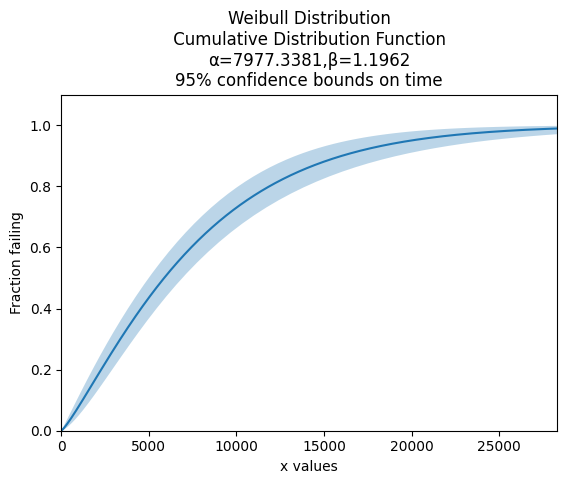

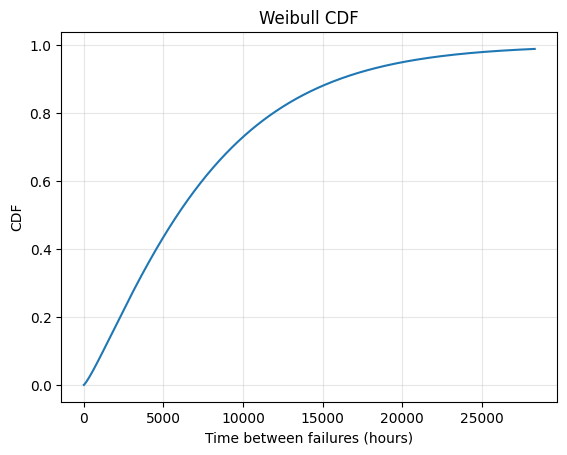

In [11]:
y_cdf = fit.distribution.CDF(x)

plt.figure()
plt.plot(x, y_cdf)
plt.xlabel("Time between failures (hours)")
plt.ylabel("CDF")
plt.title("Weibull CDF")
plt.grid(True, alpha=0.3)
savefig("WBL_20_5_CDF.png")
plt.show()

## 11) Reliability Function R(t) = Survival Function (SF)

Saved: figures/WBL_20_5_Reliability_SF.png


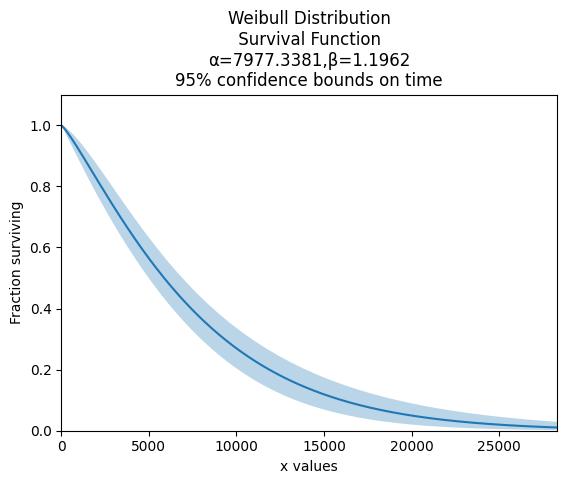

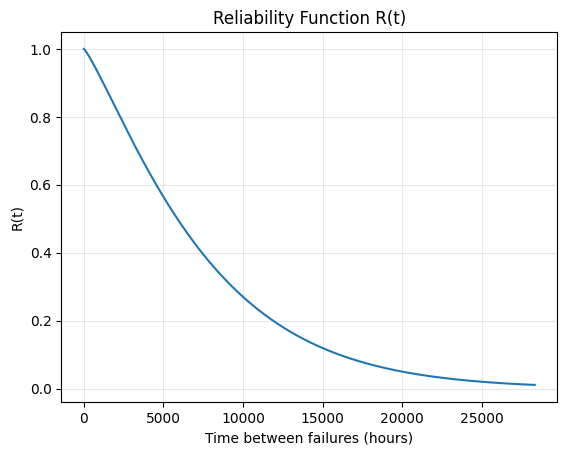

In [12]:
y_sf = fit.distribution.SF(x)

plt.figure()
plt.plot(x, y_sf)
plt.xlabel("Time between failures (hours)")
plt.ylabel("R(t)")
plt.title("Reliability Function R(t)")
plt.grid(True, alpha=0.3)
savefig("WBL_20_5_Reliability_SF.png")
plt.show()

## 12) Hazard Rate h(t) = HF

Saved: figures/WBL_20_5_Hazard_HF.png


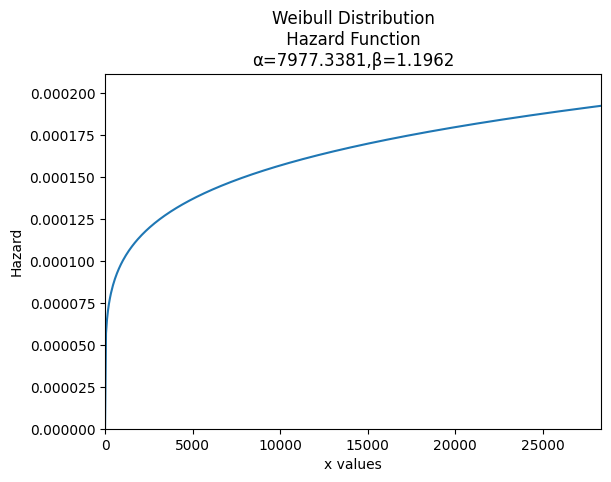

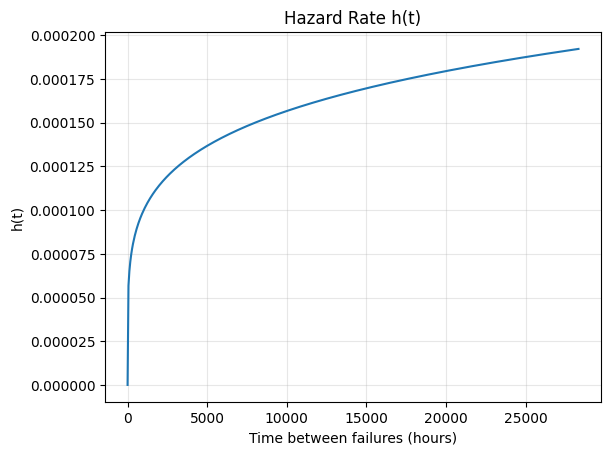

In [13]:
y_hf = fit.distribution.HF(x)

plt.figure()
plt.plot(x, y_hf)
plt.xlabel("Time between failures (hours)")
plt.ylabel("h(t)")
plt.title("Hazard Rate h(t)")
plt.grid(True, alpha=0.3)
savefig("WBL_20_5_Hazard_HF.png")
plt.show()

## 13) Weibull Probability Plot (fit check)

Jumlah interval: 88
[ 7719.41361111 11123.7475      1102.93861111  6992.57111111
  1413.82666667  3861.6375      3630.22472222  3224.72444444
  6848.73388889   507.34055556]
Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 88/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          5910.9         542.322   4938.06    7075.4
     Beta          1.2238        0.103052   1.03761    1.4434 

Goodness of fit    Value
 Log-likelihood -843.821
           AICc  1691.78
            BIC   1696.6
             AD 0.439086 



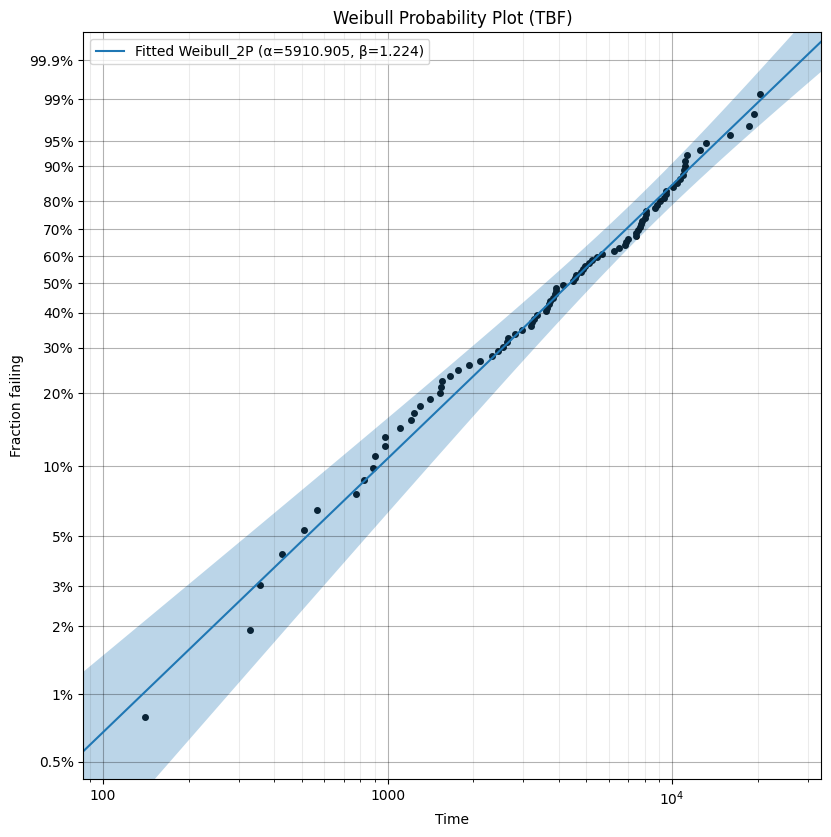

In [30]:
df["Failure_Start"] = pd.to_datetime(df["Failure_Start"])
df_fail = df[df["Event_Type"] == "FAILURE"].copy()
df_fail = df_fail.sort_values(["Asset_ID", "Failure_Start"])

df_fail["TBF_hours"] = (
    df_fail.groupby("Asset_ID")["Failure_Start"]
    .diff()
    .dt.total_seconds() / 3600
)

data = df_fail["TBF_hours"].dropna().to_numpy()

print("Jumlah interval:", len(data))
print(data[:10])

import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Weibull_2P

fit = Fit_Weibull_2P(failures=data, show_probability_plot=True)

plt.title("Weibull Probability Plot (TBF)")
plt.savefig("WBL_TBF_ProbabilityPlot.png", dpi=300, bbox_inches="tight")
plt.show()

## 14) Reliability at a target interval (decision support)

- **R(t)** = probability the interval survives beyond *t*  
- **F(t) = 1 − R(t)** = probability of failure within *t*


In [33]:
t_target = 3000  # hours (edit)

R = fit.distribution.SF(t_target)
F = 1 - R

print(f"Target interval t = {t_target} hours")
print(f"Reliability R(t): {R:.4f}")
print(f"Failure probability F(t): {F:.4f}")

Target interval t = 3000 hours
Reliability R(t): 0.6466
Failure probability F(t): 0.3534


## 15) (Colab) Download figures as a zip (optional)

In [ ]:
# If on Colab, uncomment to zip + download
# import shutil
# from google.colab import files
# shutil.make_archive("Weibull_Figures_20_5", "zip", FIG_DIR)
# files.download("Weibull_Figures_20_5.zip")

## Interpretation notes (copy into your manuscript)

- If **β < 1** → early-life issues dominate (quality, installation, commissioning)  
- If **β ≈ 1** → random failures (focus on detection, response time, spares, redundancy)  
- If **β > 1** → wear-out behavior (inspections, PM, age-based replacement)

Use **R(t)** at your planning horizon (e.g., campaign length) to justify maintenance actions with quantified risk.
